## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2022.

# ECBM E4040 - Assignment 2- Task 5: Kaggle Open-ended Competition

Kaggle is a platform for predictive modelling and analytics competitions in which companies and researchers post data and statisticians and data miners compete to produce the best models for predicting and describing the data.

If you don't have a Kaggle account, feel free to join at [www.kaggle.com](https://www.kaggle.com). To let the CAs do the grading more conveniently, please __use Lionmail to join Kaggle__ and __use UNI as your username__.

The competition is located here: https://www.kaggle.com/t/d908ef03b7244102a1e006516a6555a6

You can find detailed description about this in-class competition on the website above. Please read carefully and follow the instructions.

<span style="color:red">__TODO__:</span>

- Train a custom model for the bottle dataset classification problem. You are free to use any methods taught in the class or found by yourself on the Internet (ALWAYS provide reference to the source). General training methods include:
  - Dropout
  - Batch normalization
  - Early stopping
  - l1-norm & l2-norm penalization
- You are given the test set to generate your predictions (70% public + 30% private, but you don't know which ones are public/private). Students should achieve an accuracy on the public test set of at least 70%. Two points will be deducted for each 1% below 70% accuracy threshold (i.e. 65% accuracy will have 10 points deducted). The accuracy will be shown on the public leaderboard once you submit your prediction .csv file. The private leaderboard will be released after the competition. The final ranking is based on the private leaderboard result, not the public leaderboard.


NOTE: 
* Report your results on the Kaggle, for comparison with other students' optimal results (you can do this several times). 
* Save your best model.

__Hint__: You can start from what you implemented in task 4. Students are allowed to use pretrained networks, and utilize transfer learning. 

## Useful Information: 

- Unzip zip files in GCP or acquire administrator permission for other application installation: When you upload your dataset to your vm instances, you may want to unzip your files. However, unzip command is not built in. To use `sudo apt install unzip` or for future applications installation, you need to: 
  - Change username to default (or just restart the vm instance)
  - Type `sudo su` to get root
  - You can remove sudo for the following installation commands (e.g. `apt install unzip`).
- If you meet kernel crash (or the running never ends), you might consider using a larger memory CPU. Especially if you include large network structure like VGG, 15GB memory or more CPU is recommended
- Some python libraries that you might need to install first: pandas, scikit-learn. there are **2 OPTIONS** that you can use to install them:
  - In the envTF24 environment in linux interface, type: `pip install [package name]` 
  - In the jupyter notebook (i.e. this file), type `!pip install [package name]`. You’d better restart the virtual environment, even the instance to get these packages functional.
- You might need extra pip libraries to handle dataset, include network, etc. You can follow step 3 to install them.

## HW Submission Details:

There are two components to reporting the results of this task: 

**(A) Submission (up to 20 submissions each day) of the .csv prediction file through the Kaggle platform**. You should start doing this __VERY early__, so that students can compare their work as they are making progress with model optimization.

**(B) Submitting your best CNN model through Github Classroom repo.**

**Note** that assignments are submitted through github classroom only. All code for training your kaggle model should be done in this task 5 jupyter notebook, or in a user defined module (.py file) that is imported for use in the jupyter notebook.

<span style="color:red">__Submission content:__</span>

(i) In your Assignment 2 submission folder, create a subfolder called __KaggleModel__. Save your best model using `model.save()`. This will generate a `saved_model.pb` file, a folder called `variables`, and a folder called `checkpoints` all inside the __KaggleModel__ folder. Only upload your best model to GitHub classroom. 

(ii) <span style="color:red">If your saved model exceeds 100 MB, do not upload it to GitHub classroom (.gitignore it or you will get an error when pushing).</span> Upload it instead to Google Drive and explicitly provide the link under the 'Save your best model' cell. 

(iii) Remember to delete any intermediate results, we only want your best model. Do not upload any data files. The instructors will rerun the uploaded best model and verify against the score which you reported on the Kaggle.

**The top 10 final submissions of the Kaggle competition will receive up to 10 bonus points proportional to the private test accuracy.**

## Load Data

In [2]:
#Generate dataset
import os
import pandas as pd
import numpy as np
from PIL import Image


#Load Training images and labels
train_directory = "./data/kaggle_train_128/train_128" #TODO: Enter path for train128 folder (hint: use os.getcwd())

image_list=[]
label_list=[]
for sub_dir in os.listdir(train_directory):
    print("Reading folder {}".format(sub_dir))
    sub_dir_name=os.path.join(train_directory,sub_dir)
    for file in os.listdir(sub_dir_name):
        filename = os.fsdecode(file)
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_list.append(np.array(Image.open(os.path.join(sub_dir_name,file))))
            label_list.append(int(sub_dir))
X_train=np.array(image_list)
y_train=np.array(label_list)

#Load Test images
test_directory = "./data/kaggle_test_128/test_128"#TODO: Enter path for test128 folder (hint: use os.getcwd())
test_image_list=[]
test_df = pd.DataFrame([], columns=['Id', 'X'])
print("Reading Test Images")
for file in os.listdir(test_directory):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg") or filename.endswith(".png"):
        test_df = test_df.append({
            'Id': filename,
            'X': np.array(Image.open(os.path.join(test_directory,file)))
        }, ignore_index=True)
        
test_df['s'] = [int(x.split('.')[0]) for x in test_df['Id']]
test_df = test_df.sort_values(by=['s'])
test_df = test_df.drop(columns=['s'])
X_test = np.stack(test_df['X'])


print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)

Reading folder 1
Reading folder 3
Reading folder 0
Reading folder 2
Reading folder 4
Reading Test Images
Training data shape:  (15000, 128, 128, 3)
Training labels shape:  (15000,)
Test data shape:  (3500, 128, 128, 3)


## Build and Train Your Model Here

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


BATCH_SIZE = 100
input_shape = (128, 128, 3)
num_classes = np.unique(y_train).shape[0]
input_layer = tf.keras.layers.Input(shape=input_shape)
dense = tf.keras.applications.DenseNet121(weights='imagenet', input_tensor=input_layer, include_top=False)
x = tf.keras.layers.GlobalAveragePooling2D()(dense.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512,activation='relu')(x) 
x = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=output)
loss_type = "sparse_categorical_crossentropy" # "categorical_crossentropy"
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [4]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('model_best_weights.h5', monitor='val_loss', verbose=True, save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
]
model.compile(optimizer=Adam(lr=3e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [5]:
history = model.fit(X_train, y_train, batch_size = 100, epochs = 20, validation_split=0.1, callbacks=callbacks)

Epoch 1/20
135/135 [==============================] - 71s 365ms/step - loss: 0.9169 - accuracy: 0.6659 - val_loss: 0.0746 - val_accuracy: 0.9727

Epoch 00001: val_loss improved from inf to 0.07459, saving model to model_best_weights.h5
Epoch 2/20
135/135 [==============================] - 48s 357ms/step - loss: 0.0748 - accuracy: 0.9766 - val_loss: 0.1274 - val_accuracy: 0.9580

Epoch 00002: val_loss did not improve from 0.07459
Epoch 3/20
135/135 [==============================] - 49s 360ms/step - loss: 0.0219 - accuracy: 0.9942 - val_loss: 0.2095 - val_accuracy: 0.9427

Epoch 00003: val_loss did not improve from 0.07459
Epoch 4/20
135/135 [==============================] - 49s 363ms/step - loss: 0.0173 - accuracy: 0.9939 - val_loss: 0.3124 - val_accuracy: 0.9147

Epoch 00004: val_loss did not improve from 0.07459
Epoch 5/20
135/135 [==============================] - 49s 364ms/step - loss: 0.0380 - accuracy: 0.9879 - val_loss: 0.2556 - val_accuracy: 0.9400

Epoch 00005: val_loss did n

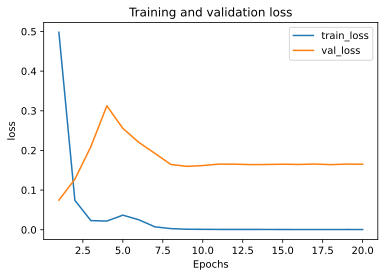

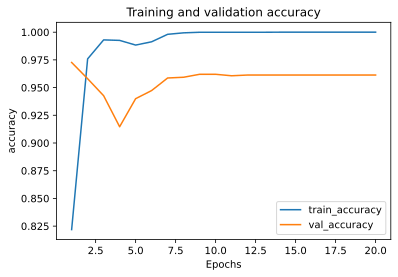

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(history, 'loss')
plot_metric(history, 'accuracy')

## Save your best model

**Link to large model on Google Drive: [insert link here]** (if model exceeds 100 MB, else upload to GitHub classroom)

In [7]:
# YOUR CODE HERE

model.save(filepath = "./KaggleModel")

INFO:tensorflow:Assets written to: ./KaggleModel/assets


## Generate .csv file for Kaggle

The following code snippet can be an example used to generate your prediction .csv file.

NOTE: If your Kaggle results are indicating random performance, then it's likely that the indices of your csv predictions are misaligned.

In [8]:
import csv
import pathlib 
# test_directory = "./data/kaggle_test_128/test_128"
test_dir = pathlib.Path('./data/kaggle_test_128')
test_dir = test_dir / 'test_128'

predicted_val = {}
for image_path in sorted(test_dir.glob("*")):
    image = tf.keras.preprocessing.image.load_img(image_path,target_size = (128, 128))
    #image = test_gen.standardize(image)
    image = np.expand_dims(image, 0)
    preds = model.predict(image)
    pred = np.argmax(preds)    
    predicted_val[image_path.name] = pred

In [9]:
import csv
with open('predicted.csv','w') as csvfile:
    fieldnames = ['Id','label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for index, l in enumerate(predicted_val):
        filename = str(index) + '.png'
        label = str(predicted_val[l])
        writer.writerow({'Id': filename, 'label': label})